# Drought hazard team SPI output processing

In [1]:
import sys
import os
import glob
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
sys.path.append('/g/data/mn51/users/jb6465/drought-github/submodules/gwls')
from gwl import get_GWL_timeslice
sys.path.append('/g/data/mn51/users/jb6465/drought-github/percentiles_spi_spei_smi')
import utils

## GWL slicing

In [2]:
# GWL slicing git hash
import subprocess

def get_submodule_hash(submodule_path):
    result = subprocess.run(['git', '-C', submodule_path, 'rev-parse', 'HEAD'], 
                            capture_output=True, text=True, check=True)
    return result.stdout.strip()

# Example usage
submodule_path = '/g/data/mn51/users/jb6465/drought-github/submodules/gwls'
commit_hash = get_submodule_hash(submodule_path)
print(f"Submodule commit hash: {commit_hash}")

Submodule commit hash: 40fe88fca1eaab8491bb3a5b99167db817b24c65


In [3]:
input_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_spi_5km/full_period/'
output_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_spi_5km/GWLs/'

files = []
files.extend(sorted(glob.glob("{}/*{}".format(input_dir, '.nc'))))

for input_file in files:
    print(f"---> GWL slicing for {input_file.rpartition('/')[-1]}")
    model_list = ['CMCC-ESM2','ACCESS-ESM1-5','ACCESS-CM2','EC-Earth3','CESM2','CNRM-ESM2-1','MPI-ESM1-2-HR', 'NorESM2-MM'] 
    target_model = [model for model in model_list if model in input_file][0]
    variant_id = utils.data_source['CMIP6'][target_model]['variant-id']
    for GWL in [1.2, 1.5, 2.0, 3.0]:
        print('= GWL'+str(GWL))
        GWL_timeslice = get_GWL_timeslice(xr.open_dataset(input_file),'CMIP6',target_model,variant_id,'ssp370',GWL)

        # write to netcdf in output_dir
        GWL_timeslice.attrs['description'] = f"Standardised Precipitation Index computed using method of McKee et al. 1993 for {target_model} GWL{str(GWL)} using a base period of 1965-2014. Further details in supporting technical documentation."
        GWL_timeslice.attrs['created'] = (datetime.now()).strftime("%d/%m/%Y %H:%M:%S")
        GWL_timeslice.attrs['comment'] = f"Using data on {input_dir}"
        GWL_timeslice.attrs['GWL'] = f"GWL {str(GWL)}. Sliced using get_GWL_timeslice function from https://github.com/AusClimateService/gwls. Submodule commit hash: {commit_hash}"
        GWL_timeslice.to_netcdf(f"{output_dir}{input_file.rpartition('/')[-1][:-3]}_GWL{str(GWL)}.nc")

---> GWL slicing for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014.nc
= GWL1.2
= GWL1.5
= GWL2.0
= GWL3.0
---> GWL slicing for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014.nc
= GWL1.2
= GWL1.5
= GWL2.0
= GWL3.0
---> GWL slicing for SPI3_AGCD-05i_ACCESS-ESM1-5_ssp370_r6i1p1f1_BOM_v1-r1_baseperiod19652014.nc
= GWL1.2
= GWL1.5
= GWL2.0
= GWL3.0
---> GWL slicing for SPI3_AGCD-05i_ACCESS-ESM1-5_ssp370_r6i1p1f1_CSIRO_v1-r1_baseperiod19652014.nc
= GWL1.2
= GWL1.5
= GWL2.0
= GWL3.0
---> GWL slicing for SPI3_AGCD-05i_CESM2_ssp370_r11i1p1f1_BOM_v1-r1_baseperiod19652014.nc
= GWL1.2
= GWL1.5
= GWL2.0
= GWL3.0
---> GWL slicing for SPI3_AGCD-05i_CESM2_ssp370_r11i1p1f1_CSIRO_v1-r1_baseperiod19652014.nc
= GWL1.2
= GWL1.5
= GWL2.0
= GWL3.0
---> GWL slicing for SPI3_AGCD-05i_CMCC-ESM2_ssp370_r1i1p1f1_BOM_v1-r1_baseperiod19652014.nc
= GWL1.2
= GWL1.5
= GWL2.0
= GWL3.0
---> GWL slicing for SPI3_AGCD-05i_CMCC-ESM2_ssp370_r1i1p1f1_CSIRO_v1-r1_baseperiod1965

## Percent time below SPI < -1

In [103]:
SPI_threshold = -1
input_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/GWLs/'
output_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/'

files = []
files.extend(sorted(glob.glob("{}/*{}".format(input_dir, '.nc'))))

In [104]:
print(f"Computing pct time below -1")
for spi_file in files:
    print(f"-> for {spi_file.rpartition('/')[-1]}")
    spi_xr = xr.open_dataset(spi_file)
    pct_below_thresh = 100*((spi_xr.SPI3)<=SPI_threshold).sum(dim='time')/len(spi_xr.SPI3.time)
    
    # write to netcdf in output_dir
    pct_below_thresh.attrs['description'] = f"Standardised Precipitation Index percent of months below -1 for input file: {spi_file.rpartition('/')[-1]} in {input_dir}. "
    pct_below_thresh.attrs['created'] = (datetime.now()).strftime("%d/%m/%Y %H:%M:%S")
    pct_below_thresh.attrs['GWL'] = f"GWL {spi_file[-6:-3]}. Sliced using get_GWL_timeslice function from https://github.com/AusClimateService/gwls. Submodule commit hash: {commit_hash}"
    pct_below_thresh.to_netcdf(f"{output_dir}{(spi_file.rpartition('/')[-1][:-3])[:5]+'pct_time_below_-1'+(spi_file.rpartition('/')[-1][:-3])[4:]}.nc", mode='w')

Computing pct time below -1
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_GWL1.2.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_GWL1.5.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_GWL2.0.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_GWL3.0.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014_GWL1.2.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014_GWL1.5.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014_GWL2.0.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014_GWL3.0.nc
-> for SPI3_AGCD-05i_ACCESS-ESM1-5_ssp370_r6i1p1f1_BOM_v1-r1_baseperiod19652014_GWL1.2.nc
-> for SPI3_AGCD-05i_ACCESS-ESM1-5_ssp370_r6i1p1f1_BOM_v1-r1_baseperiod19652014_GWL1.5.nc
-> for SPI3_AGCD-05i_ACCESS-ESM1-5_ssp370_r6i1p1f1_BOM_v1-r1_baseperiod19652014_GWL2.0.n

### 10-50-90 Percentiles for GWL and change between GWLs

In [14]:
input_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/'
output_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/'

files = []
files.extend(sorted(glob.glob("{}/*pct_time_below*baseperiod19652014*{}".format(input_dir, '.nc'))))

In [15]:
files

['/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/SPI3_pct_time_below_-1_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_GWL1.2.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/SPI3_pct_time_below_-1_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_GWL1.5.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/SPI3_pct_time_below_-1_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_GWL2.0.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/SPI3_pct_time_below_-1_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_GWL3.0.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/SPI3_pct_time_below_-1_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014_GWL1.2.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/SPI3_pct_time_below_-1_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014_GWL1.5.nc',
 '/g/data/ia39/ncra/drought_ar

In [16]:
for GWL in [1.2, 1.5, 2.0, 3.0]:
    print(f"Computing 10-50-90th percentiles of MME for GWL{str(GWL)}")
    GWL_file_list = [file for file in files if f"GWL{str(GWL)}" in file]
    GWL_ens_list = [file[91:-35] for file in files if f"GWL{str(GWL)}" in file]
    MME_xr = xr.concat([xr.open_dataset(file).assign_coords(MME=ensemble) for file, ensemble in zip(GWL_file_list, GWL_ens_list)], dim='MME')
    
    p10_50_90_xr = MME_xr.quantile([0.1,0.5,0.9], dim ='MME')
    p10_50_90_xr.attrs['description'] = f"10th, 50th and 90th percentile of MME for pct of months below Standardised Precipitation Index of -1. "
    p10_50_90_xr.attrs['comment'] = f"Using data on {input_dir}"
    p10_50_90_xr.attrs['created'] = (datetime.now()).strftime("%d/%m/%Y %H:%M:%S")
    p10_50_90_xr.attrs['GWL'] = f"GWL {str(GWL)}. Sliced using get_GWL_timeslice function from https://github.com/AusClimateService/gwls. Submodule commit hash: {commit_hash}"
    p10_50_90_xr.attrs['cell_methods'] = "quantile: 0.1, 0.5, 0.9"
    p10_50_90_xr.to_netcdf(f"{output_dir}SPI3_pct_time_below_-1_GWL_{str(GWL)}_percentiles_10-50-90.nc", mode='w')

    #10-50-90th percentile of percent change 
    if GWL != 1.2:
        print(f"---> Computing MME change 10-50-90th percentiles for GWL{str(GWL)} and GWL1.2")
        GWL12_file_list = [file for file in files if "GWL1.2" in file]
        GWL12_ens_list = [file[91:-35] for file in files if "GWL1.2" in file]
        MME_GWL12_xr = xr.concat([xr.open_dataset(file).assign_coords(MME=ensemble) for file, ensemble in zip(GWL12_file_list, GWL12_ens_list)], dim='MME')
            
        MME_change_p10_50_90 = (MME_xr-MME_GWL12_xr).quantile([0.1,0.5,0.9], dim ='MME')
        MME_change_p10_50_90.attrs['description'] = f"Change between GWL{str(GWL)} and GWL1.2 for 10th, 50th and 90th percentile of MME for pct of months below Standardised Precipitation Index of -1. "
        MME_change_p10_50_90.attrs['comment'] = f"Using data on {input_dir}"
        MME_change_p10_50_90.attrs['created'] = (datetime.now()).strftime("%d/%m/%Y %H:%M:%S")
        MME_change_p10_50_90.attrs['cell_methods'] = "quantile: 0.1, 0.5, 0.9"
        MME_change_p10_50_90.to_netcdf(f"{output_dir}SPI3_pct_time_below_-1_MME_change_GWL{str(GWL)}_to_GWL1.2_percentiles_10-50-90.nc", mode='w')

Computing 10-50-90th percentiles of MME for GWL1.2
Computing 10-50-90th percentiles of MME for GWL1.5
---> Computing MME change 10-50-90th percentiles for GWL1.5 and GWL1.2
Computing 10-50-90th percentiles of MME for GWL2.0
---> Computing MME change 10-50-90th percentiles for GWL2.0 and GWL1.2
Computing 10-50-90th percentiles of MME for GWL3.0
---> Computing MME change 10-50-90th percentiles for GWL3.0 and GWL1.2


GWL1.5-GWL1.2


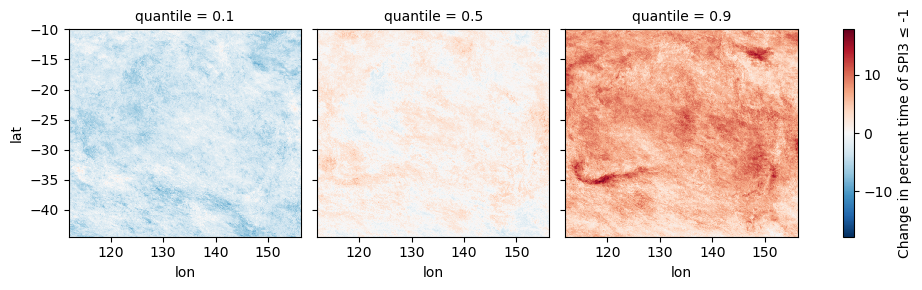

GWL2.0-GWL1.2


<Figure size 640x480 with 0 Axes>

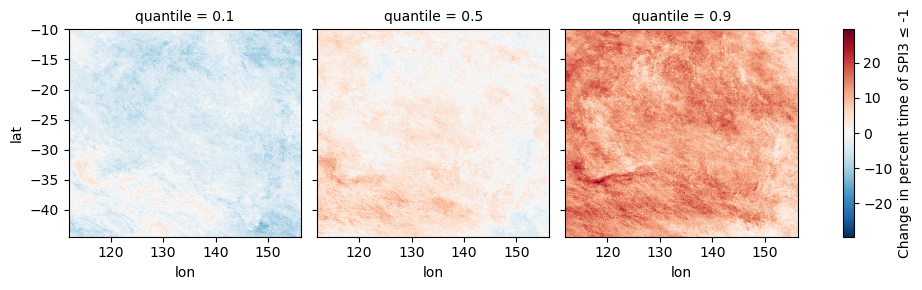

GWL3.0-GWL1.2


<Figure size 640x480 with 0 Axes>

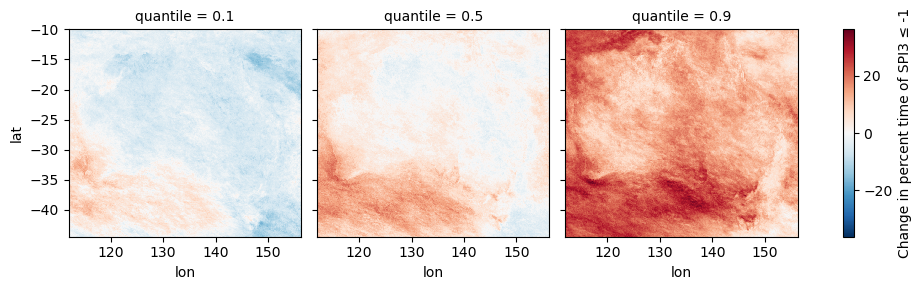

<Figure size 640x480 with 0 Axes>

In [17]:
#quick check of outputs
for GWL in [1.5, 2.0, 3.0]:
    print(f"GWL{str(GWL)}-GWL1.2")
    quick_check_ds = xr.open_dataset(f"/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/SPI3_pct_time_below_-1_MME_change_GWL{str(GWL)}_to_GWL1.2_percentiles_10-50-90.nc")
    quick_check_ds.SPI3.plot(col="quantile",cmap="RdBu_r", cbar_kwargs={'label': 'Change in percent time of SPI3 ≤ -1'})
    plt.show()
    plt.clf()

## Plotting

In [3]:
cd /g/data/mn51/users/jb6465/drought-github/submodules/plotting_maps

/g/data/mn51/users/jb6465/drought-github/submodules/plotting_maps


In [4]:
from acs_plotting_maps import plot_acs_hazard, regions_dict, cmap_dict, tick_dict

CPU times: user 1min 1s, sys: 120 ms, total: 1min 1s
Wall time: 1min 1s


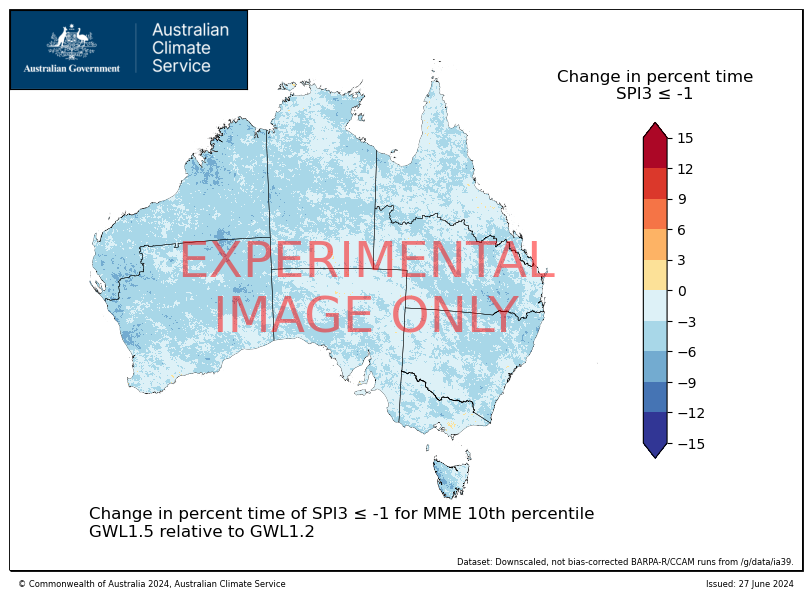

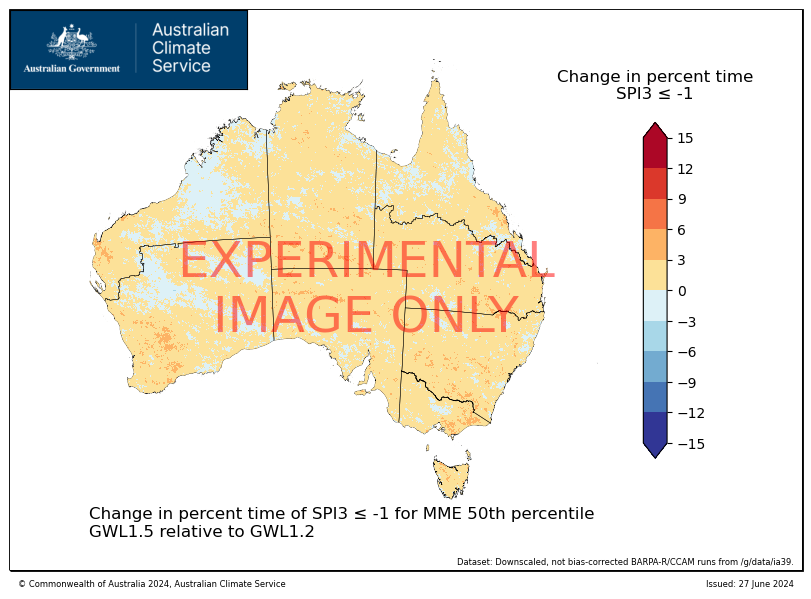

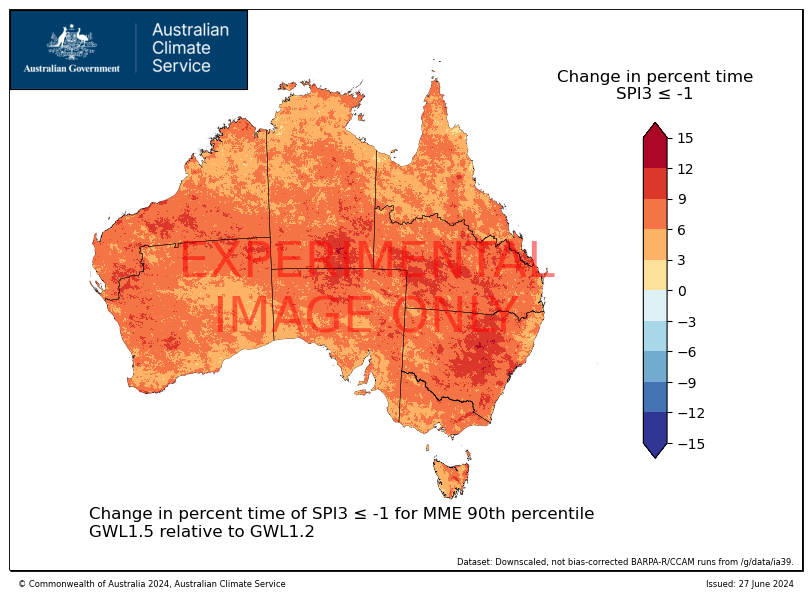

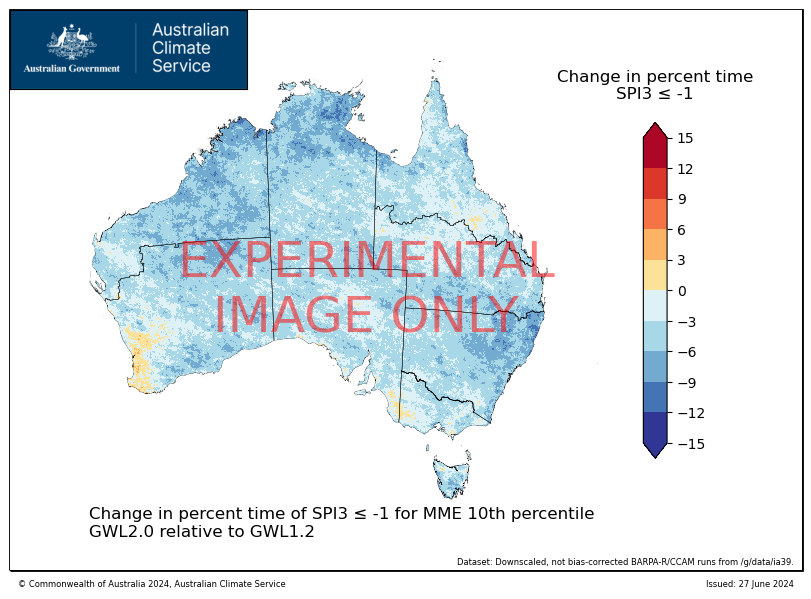

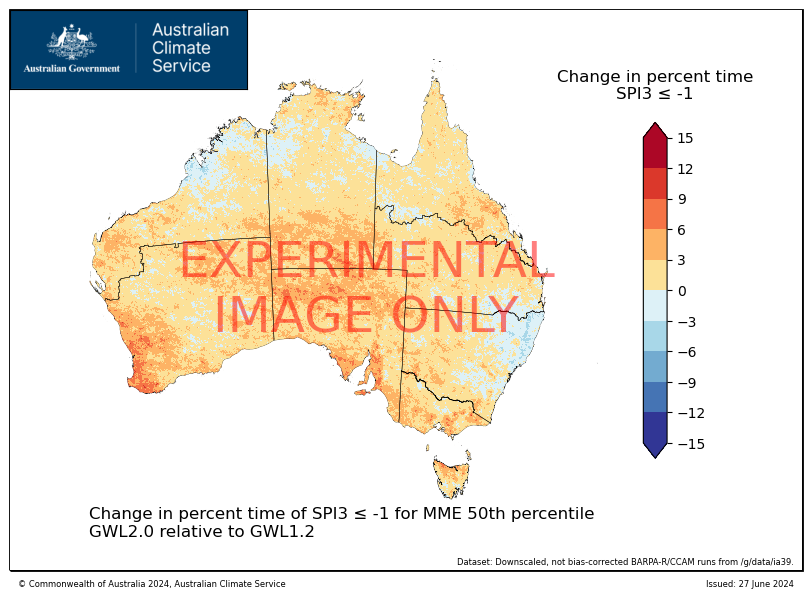

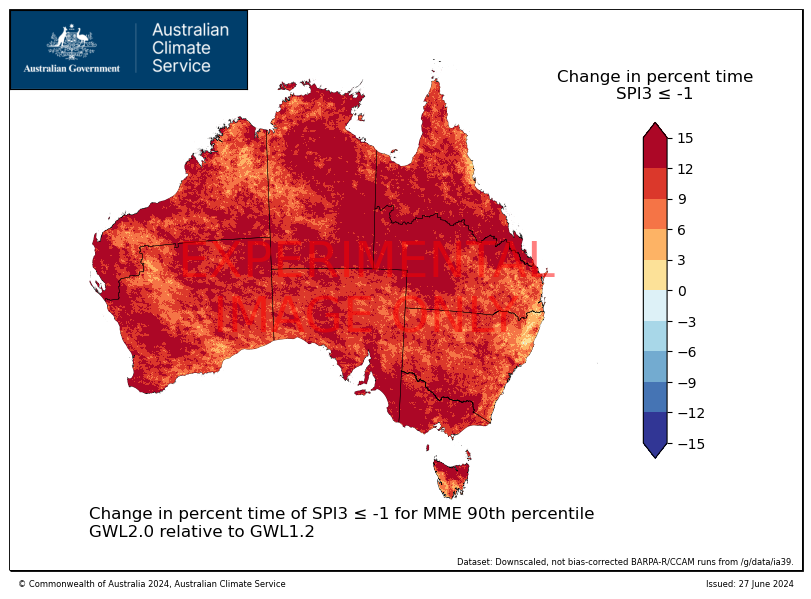

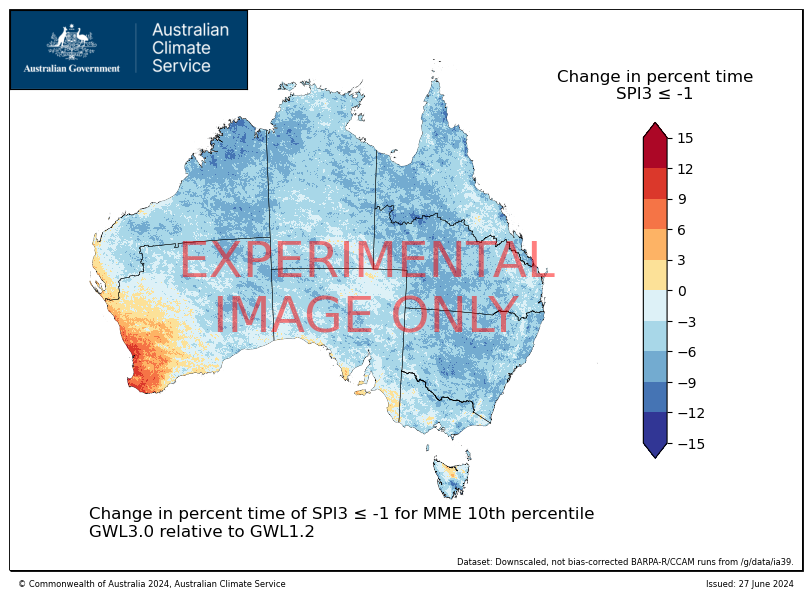

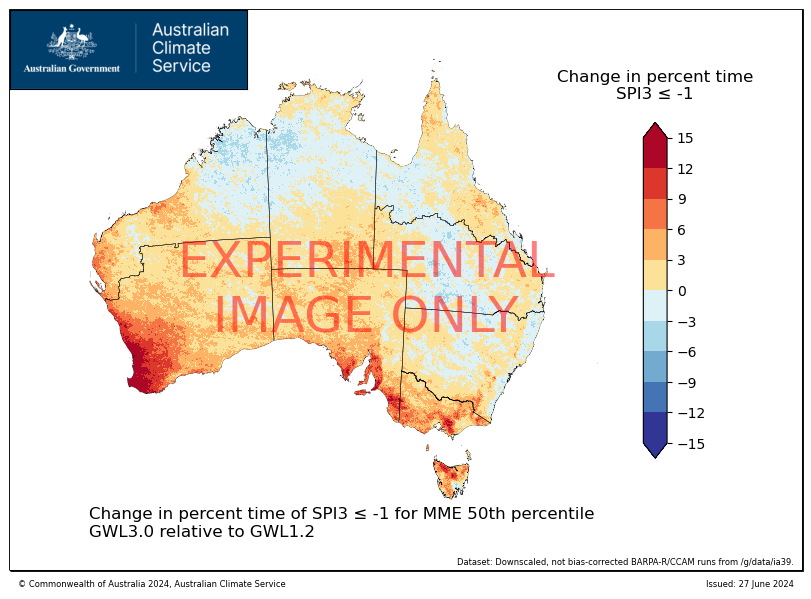

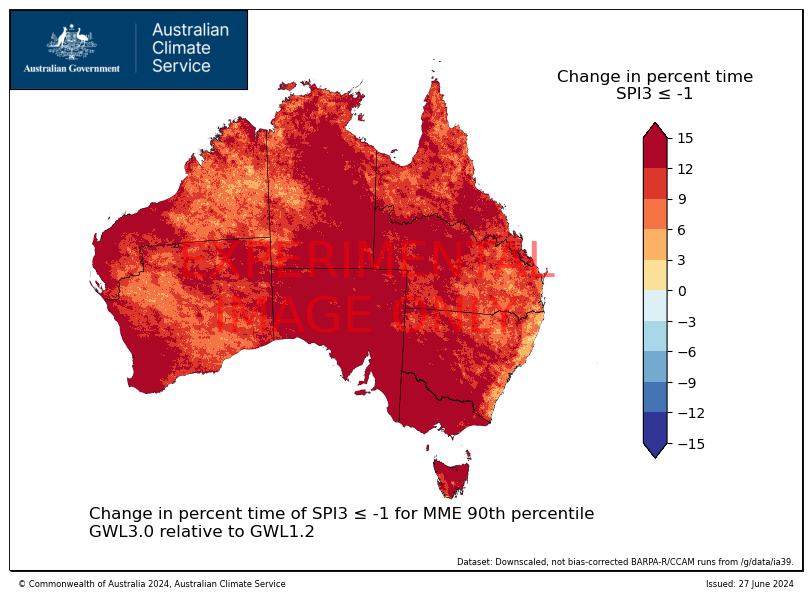

In [47]:
%%time

for GWL in [1.5, 2.0, 3.0]:
    for percentile in [0.1, 0.5, 0.9]:
        plot_file = f'/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/SPI3_pct_time_below_-1_MME_change_GWL{str(GWL)}_to_GWL1.2_percentiles_10-50-90.nc'
        
        plot_acs_hazard(data = xr.open_dataset(plot_file).sel(quantile=percentile).SPI3,
                        regions = regions_dict['ncra_regions'],
                        cmap = cmap_dict["anom_b2r"],
                        ticks = np.arange(-15, 15.1, 3),
                        cbar_label = "Change in percent time\nSPI3 ≤ -1",
                        cbar_extend = "both",
                        title = f"Change in percent time of SPI3 ≤ -1 for MME {str(int(percentile*100))}th percentile",
                        dataset_name = "Downscaled, not bias-corrected BARPA-R/CCAM runs from /g/data/ia39.",
                        date_range = f"{plot_file[-40:-34]} relative to GWL1.2",
                        contourf = False,
                        contour = False
                       );

CPU times: user 1min, sys: 91.6 ms, total: 1min
Wall time: 1min 2s


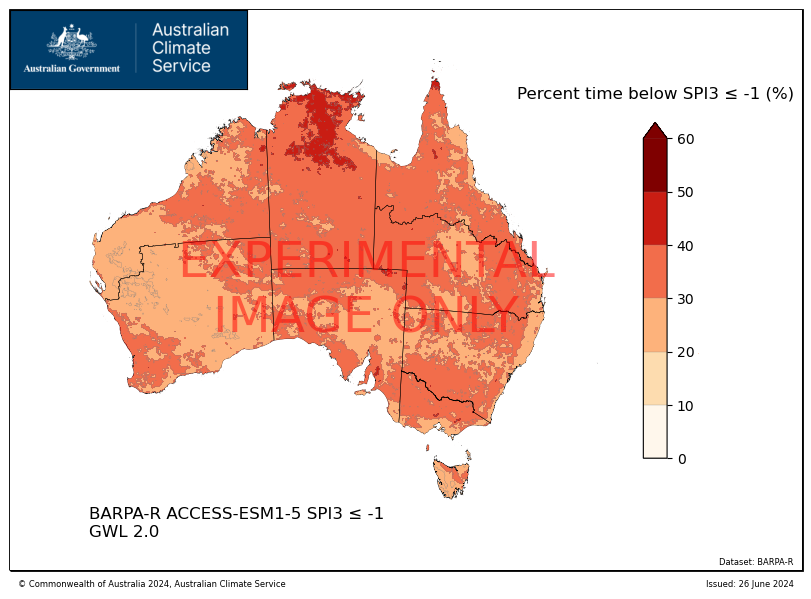

In [346]:
%%time
plot_acs_hazard(data = xr.open_dataset('/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/SPI3_pct_time_below_-1_AGCD-05i_ACCESS-ESM1-5_ssp370_r6i1p1f1_BOM_v1-r1_baseperiod19652014_GWL2.0.nc').SPI3,
                    regions = regions_dict['ncra_regions'],
                    cmap = cmap_dict["OrRd"],
                    ticks = np.arange(0, 60.1, 10),
                    cbar_label = "Percent time below SPI3 ≤ -1 (%)",
                    cbar_extend = "max",
                    title = "BARPA-R ACCESS-ESM1-5 SPI3 ≤ -1",
                    dataset_name = "BARPA-R",
                    date_range = "GWL 2.0",
                   );

## Regional statistics

In [7]:
cd /g/data/mn51/users/jb6465/drought-github/submodules/plotting_maps

/g/data/mn51/users/jb6465/drought-github/submodules/plotting_maps


In [8]:
from acs_area_statistics import acs_regional_stats, regions

In [85]:
input_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/'

files = []
files.extend(sorted(glob.glob("{}/*MME_change*{}".format(input_dir, '.nc'))))

In [93]:
from IPython.display import display
for change_grid in files:
    for percentile in [0.1, 0.5, 0.9]:
        print(f'--> Calculating spatial summary statistics for {change_grid[-40:-24].replace("_", " ")} for {str(int(percentile*100))}th MME percentile.')
        print()
        ds = xr.open_dataset(change_grid).sel(quantile=percentile).rename({'SPI3': 'change_in_pct_time_SPI3_below_-1'})
        mask_frac = regions.mask_3D_frac_approx(ds)
        dims = ("lat", "lon",)
        regional_summary_ds = acs_regional_stats(ds=ds,var="change_in_pct_time_SPI3_below_-1", mask=mask_frac, dims = dims, how = ["min", "median", "max"])
        display(regional_summary_ds)
        regional_summary_ds.to_csv(f'/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/MME_change_spatial_summary_statistics/{change_grid[-40:-24]}_change_for_MME_{str(int(percentile*100))}th_percentile.csv')

--> Calculating spatial summary statistics for GWL1.5 to GWL1.2 for 10th MME percentile.



,abbrevs,names,change_in_pct_time_SPI3_below_-1_min,change_in_pct_time_SPI3_below_-1_median,change_in_pct_time_SPI3_below_-1_max
region,,,,,
0,WANorth,Western Australia North,-8.116769,-4.250000,-0.750000
1,WASouth,Western Australia South,-8.578670,-3.833333,0.817122
2,NSW,New South Wales and Australian Capital Territory,-8.500000,-3.083333,0.499785
3,VIC,Victoria,-6.916667,-2.606117,1.333086
4,SA,South Australia,-6.576507,-2.750000,0.500000
5,TAS,Tasmania,-9.333333,-3.750000,0.000000
6,NT,Northern Territory,-7.500000,-3.250000,1.250000
7,QLDNorth,Queensland North,-6.833333,-2.833333,0.916667
8,QLDSouth,Queensland South,-7.333333,-3.083333,0.416667


--> Calculating spatial summary statistics for GWL1.5 to GWL1.2 for 50th MME percentile.



,abbrevs,names,change_in_pct_time_SPI3_below_-1_min,change_in_pct_time_SPI3_below_-1_median,change_in_pct_time_SPI3_below_-1_max
region,,,,,
0,WANorth,Western Australia North,-3.333333,0.000000,4.583333
1,WASouth,Western Australia South,-3.333333,0.416667,5.416667
2,NSW,New South Wales and Australian Capital Territory,-2.916667,1.250000,5.402943
3,VIC,Victoria,-2.500000,1.250000,5.000000
4,SA,South Australia,-2.500000,1.250000,4.583333
5,TAS,Tasmania,-4.166667,1.250000,4.583333
6,NT,Northern Territory,-2.916667,0.833333,4.583333
7,QLDNorth,Queensland North,-2.500000,0.416667,5.833333
8,QLDSouth,Queensland South,-2.500000,1.250000,5.383841


--> Calculating spatial summary statistics for GWL1.5 to GWL1.2 for 90th MME percentile.



,abbrevs,names,change_in_pct_time_SPI3_below_-1_min,change_in_pct_time_SPI3_below_-1_median,change_in_pct_time_SPI3_below_-1_max
region,,,,,
0,WANorth,Western Australia North,2.500000,7.083333,11.583273
1,WASouth,Western Australia South,1.916667,6.750000,14.540203
2,NSW,New South Wales and Australian Capital Territory,1.666667,7.916667,13.250000
3,VIC,Victoria,2.918565,6.666667,11.833333
4,SA,South Australia,2.380583,6.833333,12.503870
5,TAS,Tasmania,1.666667,5.583333,10.916667
6,NT,Northern Territory,1.632514,6.666667,13.412338
7,QLDNorth,Queensland North,1.083333,6.083333,12.215385
8,QLDSouth,Queensland South,2.835930,7.916667,12.416667


--> Calculating spatial summary statistics for GWL2.0 to GWL1.2 for 10th MME percentile.



,abbrevs,names,change_in_pct_time_SPI3_below_-1_min,change_in_pct_time_SPI3_below_-1_median,change_in_pct_time_SPI3_below_-1_max
region,,,,,
0,WANorth,Western Australia North,-12.108544,-5.333333,1.320347
1,WASouth,Western Australia South,-10.416667,-4.000000,5.520128
2,NSW,New South Wales and Australian Capital Territory,-12.000000,-4.750000,0.580185
3,VIC,Victoria,-8.466558,-2.833333,2.583333
4,SA,South Australia,-8.333333,-3.500000,2.500000
5,TAS,Tasmania,-13.161599,-3.916667,1.666667
6,NT,Northern Territory,-12.166667,-4.583333,0.833333
7,QLDNorth,Queensland North,-11.415883,-3.250000,1.749582
8,QLDSouth,Queensland South,-9.916667,-3.750000,1.250000


--> Calculating spatial summary statistics for GWL2.0 to GWL1.2 for 50th MME percentile.



,abbrevs,names,change_in_pct_time_SPI3_below_-1_min,change_in_pct_time_SPI3_below_-1_median,change_in_pct_time_SPI3_below_-1_max
region,,,,,
0,WANorth,Western Australia North,-5.000000,1.250000,7.083333
1,WASouth,Western Australia South,-2.916667,2.500000,10.452754
2,NSW,New South Wales and Australian Capital Territory,-5.833333,0.833333,7.083333
3,VIC,Victoria,-2.083333,2.500000,10.000000
4,SA,South Australia,-2.083333,3.333333,9.166667
5,TAS,Tasmania,-5.134636,2.083333,7.916667
6,NT,Northern Territory,-4.583333,1.666667,7.916667
7,QLDNorth,Queensland North,-3.750000,0.833333,8.332783
8,QLDSouth,Queensland South,-3.750000,1.250000,6.666667


--> Calculating spatial summary statistics for GWL2.0 to GWL1.2 for 90th MME percentile.



,abbrevs,names,change_in_pct_time_SPI3_below_-1_min,change_in_pct_time_SPI3_below_-1_median,change_in_pct_time_SPI3_below_-1_max
region,,,,,
0,WANorth,Western Australia North,2.416667,11.250000,20.391578
1,WASouth,Western Australia South,2.833333,11.333333,24.230395
2,NSW,New South Wales and Australian Capital Territory,-1.333333,10.083333,19.162905
3,VIC,Victoria,6.156804,12.916667,20.666667
4,SA,South Australia,5.416667,11.166667,21.157582
5,TAS,Tasmania,1.131213,11.000000,19.416667
6,NT,Northern Territory,3.250000,12.833333,20.480323
7,QLDNorth,Queensland North,1.918353,12.416667,19.909888
8,QLDSouth,Queensland South,1.422754,12.416667,21.250000


--> Calculating spatial summary statistics for GWL3.0 to GWL1.2 for 10th MME percentile.



,abbrevs,names,change_in_pct_time_SPI3_below_-1_min,change_in_pct_time_SPI3_below_-1_median,change_in_pct_time_SPI3_below_-1_max
region,,,,,
0,WANorth,Western Australia North,-11.854279,-5.666667,7.492462
1,WASouth,Western Australia South,-9.166667,-2.666667,15.339737
2,NSW,New South Wales and Australian Capital Territory,-11.000000,-5.666667,1.251579
3,VIC,Victoria,-9.373518,-3.750000,2.083333
4,SA,South Australia,-9.165614,-3.666667,4.666667
5,TAS,Tasmania,-13.186315,-3.916667,5.416667
6,NT,Northern Territory,-10.916667,-4.833333,0.916667
7,QLDNorth,Queensland North,-12.164812,-5.500000,1.248440
8,QLDSouth,Queensland South,-11.916667,-5.750000,0.833333


--> Calculating spatial summary statistics for GWL3.0 to GWL1.2 for 50th MME percentile.



,abbrevs,names,change_in_pct_time_SPI3_below_-1_min,change_in_pct_time_SPI3_below_-1_median,change_in_pct_time_SPI3_below_-1_max
region,,,,,
0,WANorth,Western Australia North,-6.250000,0.000000,11.375441
1,WASouth,Western Australia South,-4.166667,2.916667,22.916667
2,NSW,New South Wales and Australian Capital Territory,-5.000000,0.000000,9.961864
3,VIC,Victoria,-2.083223,4.166667,14.583333
4,SA,South Australia,-2.916667,2.500000,14.583333
5,TAS,Tasmania,-6.241324,4.583333,14.583333
6,NT,Northern Territory,-6.250000,0.000000,7.902562
7,QLDNorth,Queensland North,-4.583333,0.000000,7.210448
8,QLDSouth,Queensland South,-5.416667,-0.416667,7.083333


--> Calculating spatial summary statistics for GWL3.0 to GWL1.2 for 90th MME percentile.



,abbrevs,names,change_in_pct_time_SPI3_below_-1_min,change_in_pct_time_SPI3_below_-1_median,change_in_pct_time_SPI3_below_-1_max
region,,,,,
0,WANorth,Western Australia North,1.750000,9.916667,22.326851
1,WASouth,Western Australia South,4.500000,11.000000,31.963556
2,NSW,New South Wales and Australian Capital Territory,0.750000,11.916667,26.989943
3,VIC,Victoria,8.583603,21.000000,32.250000
4,SA,South Australia,8.583333,16.916667,30.995997
5,TAS,Tasmania,2.857576,17.299107,29.916667
6,NT,Northern Territory,2.000000,13.083333,25.182296
7,QLDNorth,Queensland North,3.250000,11.166667,20.493817
8,QLDSouth,Queensland South,2.669018,11.750000,19.666667
